# **Analysis tools and quality control (QC)**

In this exercise, you will begin to learn about the standard workflow for analyzing scRNA-seq count data in Python. As single cell data is complex and often tailored to the particular experimental design, so there is not one “correct” approach to analyzing these data. However, certain steps have become accepted as a sort of standard "best practice." 

Current best practices in single-cell RNA-seq analysis are explained in a recent [Nature Review](https://www.nature.com/articles/s41576-023-00586-w)


## Loading scRNAseq data

After the generation of the count matrices with cellranger, the next step is the data analysis. The scanpy package is currently the most popular software in Python to do this. To start working with scanpy, you must import the package into your Jupyter notebook as follows:

# Downloading the course data

In [ ]:
For Mac-Users: To download and extract the dataset, copy-paste these commands inside the terminal tab:

{bash}
wget https://single-cell-transcriptomics-python.s3.eu-central-1.amazonaws.com/course_data.tar.gz
tar -xvf course_data.tar.gz
rm course_data.tar.gz
If on Windows

If you're using Windows, you can directly open the [link] https://single-cell-transcriptomics-python.s3.eu-central-1.amazonaws.com/course_data.tar.gz in your browser, and downloading will start automatically. 
Unpack the tar.gz file in the directory where you want to work in during the course.


Have a look at the data directory you have downloaded. It should contain the following:

course_data
├── count_matrices
│   ├── ETV6-RUNX1_1
│   │   └── outs
│   │       └── filtered_feature_bc_matrix
│   │           ├── barcodes.tsv.gz
│   │           ├── features.tsv.gz
│   │           └── matrix.mtx.gz
│   ├── ETV6-RUNX1_2
│   │   └── outs
│   │       └── filtered_feature_bc_matrix
│   │           ├── barcodes.tsv.gz
│   │           ├── features.tsv.gz
│   │           └── matrix.mtx.gz
│   ├── ETV6-RUNX1_3
│   │   └── outs
│   │       └── filtered_feature_bc_matrix
│   │           ├── barcodes.tsv.gz
│   │           ├── features.tsv.gz
│   │           └── matrix.mtx.gz
│   ├── PBMMC_1
│   │   └── outs
│   │       └── filtered_feature_bc_matrix
│   │           ├── barcodes.tsv.gz
│   │           ├── features.tsv.gz
│   │           └── matrix.mtx.gz
│   ├── PBMMC_2
│   │   └── outs
│   │       └── filtered_feature_bc_matrix
│   │           ├── barcodes.tsv.gz
│   │           ├── features.tsv.gz
│   │           └── matrix.mtx.gz
│   └── PBMMC_3
│       └── outs
│           └── filtered_feature_bc_matrix
│               ├── barcodes.tsv.gz
│               ├── features.tsv.gz
│               └── matrix.mtx.gz
└── reads
    ├── ETV6-RUNX1_1_S1_L001_I1_001.fastq.gz
    ├── ETV6-RUNX1_1_S1_L001_R1_001.fastq.gz
    └── ETV6-RUNX1_1_S1_L001_R2_001.fastq.gz

20 directories, 21 files
This data comes from:

Caron M, St-Onge P, Sontag T, Wang YC, Richer C, Ragoussis I, et al. Single-cell analysis of childhood leukemia reveals a link between developmental states and ribosomal protein expression as a source of intra-individual heterogeneity. Scientific Reports. 2020;10:1–12. Available from: http://dx.doi.org/10.1038/s41598-020-64929-x



In [3]:
import scanpy as sc

An excellent resource for documentation on scanpy can be found on the software page at the following [link](https://scanpy.readthedocs.io/en/stable/).

There are some supplemental packages for data handling and visualization that are also very useful to import into your notebook as well.

In [2]:
import pandas as pd # for handling data frames (i.e. data tables)
import numpy as np # for handling numbers, arrays, and matrices
import matplotlib.pyplot as plt # plotting package

First, we will load a file specifying the different samples, and create a dictionary "datadirs" specifying the location of the count data:

In [21]:
sample_info = pd.read_csv("course_data/sample_info_course.csv")

datadirs = {}
for sample_name in sample_info["SampleName"]:
    if "PBMMC" in sample_name:
        datadirs[sample_name] = "course_data/count_matrices/" + sample_name + "/outs/filtered_feature_bc_matrix"

To run through a typical scanpy analysis, we will use the files that are in the directory outs/filtered_feature_bc_matrix. This directory is part of the output generated by CellRanger.

We will use the list of file paths generated in the previous step to load each sample into a separate AnnData object. We will then store all six of those samples in a list called adatas, and combine them into a single AnnData object for our analysis.

In [7]:
adatas = []
for sample in datadirs.keys():
    print("Loading: ", sample)
    curr_adata = sc.read_10x_mtx(datadirs[sample]) # load file into an AnnData object
    curr_adata.obs["sample"] = sample
    curr_adata.X = curr_adata.X.toarray()
    adatas.append(curr_adata)
    
adata = sc.concat(adatas) # combine all samples into a single AnnData object
adata.obs_names_make_unique() # make sure each cell barcode has a unique identifier

Loading:  PBMMC_1
Loading:  PBMMC_2
Loading:  PBMMC_3


/Users/melike/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


The AnnData object is similar to a detailed spreadsheet! Some basic commands to view the object are shown below. For a new dataset, there will be little to no metdata other than Cell IDs and gene names, but as you perform analyses, the metadata fields will be populated with more detail.

**Exercise 1**: Check what’s in the adata object, by typing `adata` in the Python console. How many gene features are in there? And how many cells?

## The AnnData object

The `adata` object we have created has the class AnnData. The object contains the single-cell count matrix, accessible with the command `adata.X` as well as various slots that specify sample metadata. This metadata is pretty limited when first loading the output from cellranger, but we will populate it with more useful information (i.e., cluster information) in later steps of the analysis.

To access the metadata corresponding to the cells (i.e. cell barcode, batch), you can enter the command `adata.obs`. To access the metadata corresponding to the genes (i.e, gene names, chromosome, etc), you can enter the command `adata.var`. These commands return a `pandas.dataframe` object. This data frame can be manipulated using any functions from the `pandas` package, including sum(), mean(), groupby(), and value_counts().

In [8]:
adata.X # view the count matrix (rows x columns, cells x genes)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
adata.obs.head() # view a pandas data frame containing metadata on the cells

,sample
AAACCTGCAGACGCAA-1,PBMMC_1
AAACCTGTCATCACCC-1,PBMMC_1
AAAGATGCATAAAGGT-1,PBMMC_1
AAAGCAAAGCAGCGTA-1,PBMMC_1
AAAGCAACAATAACGA-1,PBMMC_1


In [10]:
adata.var.head() # view a pandas data frame containing metadata on the cells

""
RP11-34P13.3
FAM138A
OR4F5
RP11-34P13.7
RP11-34P13.8


**Exercise 2**: Use the pandas `value_counts()` function to determine how many cells were collected for each of the six samples saved into your adata object? Keep in mind, since this is cell-specific metadata, we will want to work with the data frame returned by typing `adata.obs`.

## Quality control

In general, quality control (QC) should be done before any downstream analysis is performed. How the data is cleaned will likely have huge effects on downstream results, so it’s imperative to invest the time in choosing QC methods that you think are appropriate for your data! There are some "best practices" but these are by no means strict standards and also have certain limitations: https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

Goals:
- Filter the data to only include cells that are of high quality. This includes empty droplets, cells with a low total number of UMIs, doublets (two cells that got the same cell barcode), and dying cells (with a high fraction of mitochondrial counts).

Challenges:
- Delineating cells that are poor quality from less complex cell types
- Choosing appropriate thresholds for filtering, so as to keep high quality cells without removing biologically relevant cell types or cell states.

Before analyzing the scRNA-seq gene expression data, we should ensure that all cellular barcode data corresponds to viable cells. Cell QC is commonly performed based on three QC covariates:
- Library size: the number of counts per barcode (count depth)
- Detected genes: the number of genes per barcode
- Mitochondrial counts: the fraction of counts from mitochondrial genes per barcode.

Library size: First, consider the total number of counts (UMIs) detected per cell. Cells with few counts are likely to have been broken or failed to capture a cell, and should thus be removed. Cells with many counts above the average for a sample are likely to be doublets, or two cells encapsulated in the gel bead during the protocol.

The histogram function is: `plt.hist()`
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

Tip: each function, such as `plt.hist()` has a set of required arguments. To view those required arguments, as well as an optional arguments, from your jupyter notebook, simply click with your cursor between the `()` parenthesis of the function, and tab `tab+shift` on your keyboard.

In [12]:
n_counts_array = adata.X.sum(axis=1) # axis=1 to sum over genes, axis=0 to sum over cells
adata.obs['n_counts'] = n_counts_array

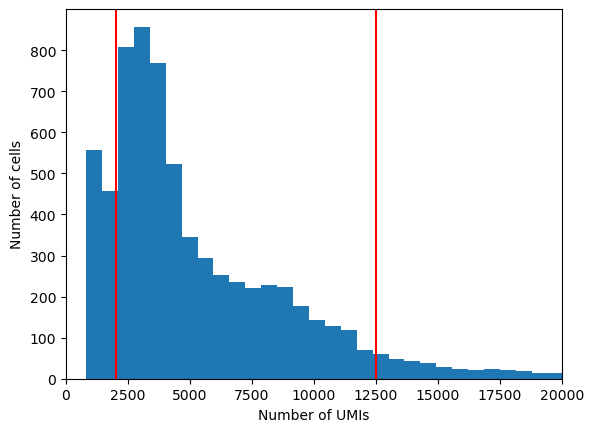

In [13]:
plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Number of UMIs")
plt.ylabel("Number of cells")
plt.axvline(2000, c="r") # choose a lower cutoff for total UMIs
plt.axvline(12500, c="r") # choose a upper cutoff for total UMIs
plt.xlim(0, 20000)
plt.show()

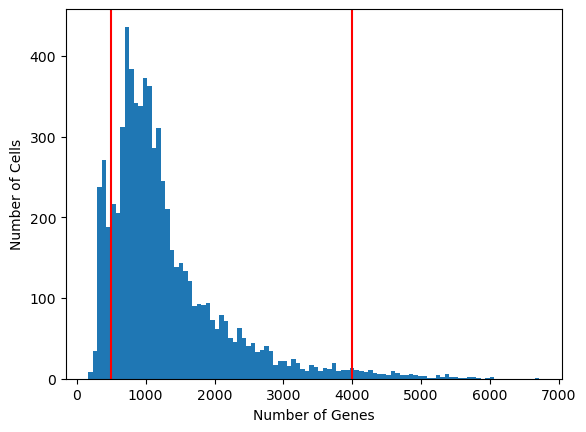

In [14]:
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes

plt.hist(adata.obs['n_genes'], bins=100)
plt.axvline(500, c="r") # choose a lower cutoff for number of detected genes
plt.axvline(4000, c="r") # choose a upper cutoff for number of detected genes
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

Next, we want to consider filtering cells with high levels of certain classes of genes, namely mitochondrial, ribosomal, and/or hemoglobin genes. There is a different rationale for filtering cells with high levels of these gene classes:

- Mitochondrial genes: If a cell membrane is damaged, it looses free RNA quicker compared to mitochondrial RNA, because the latter is part of the mitochondrion. A high relative amount of mitochondrial counts can therefore point to damaged cells (Lun et al. 2016).
- Ribosomal genes: Are not rRNA (ribosomal RNA) but is mRNA that code for ribosomal proteins. They do not point to specific issues, but it can be good to have a look at their relative abundance. They can have biological relevance (e.g. Caron et al. 2020).
- Hemoglobin genes: these transcripts are very abundant in erythrocytes. Depending on your application, you can expect ‘contamination’ of erythrocytes and select against it.

In order to have an idea about the relative counts of these type of genes in our dataset, we can calculate their expression as relative counts in each cell. We do that by selecting genes based on patterns (e.g. ^MT- matches with all gene names starting with MT, i.e. mitochondrial genes):

In [15]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [16]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20]) # this step can be a little slow to run

Run the commands and check out the metadata data frame at `adata.obs`. What has changed?

## Plotting experiment metadata

**Exercise 3**: Using scanpy's `sc.pl.violin` function, create a violin plot of the percent of counts corresponding to mitochondrial, ribosomal, and hemoglobin genes per cell. Choose an upper boundary to filter out poor quality cells with high mitochondrial counts. Note that we might want to view the results as a separate violin plot for each of our six samples. To do this, please use the optional `groupby="sample"` argument.

Please note that depending on your experimental setup, it might not make sense to filter on all these criteria.

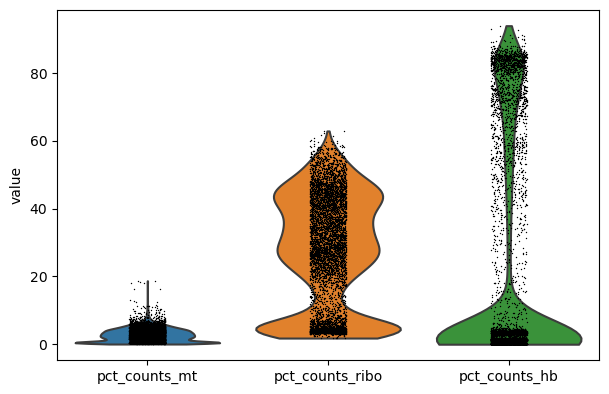

In [17]:
# Violin plots for all samples together
sc.pl.violin(adata, ["pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"])

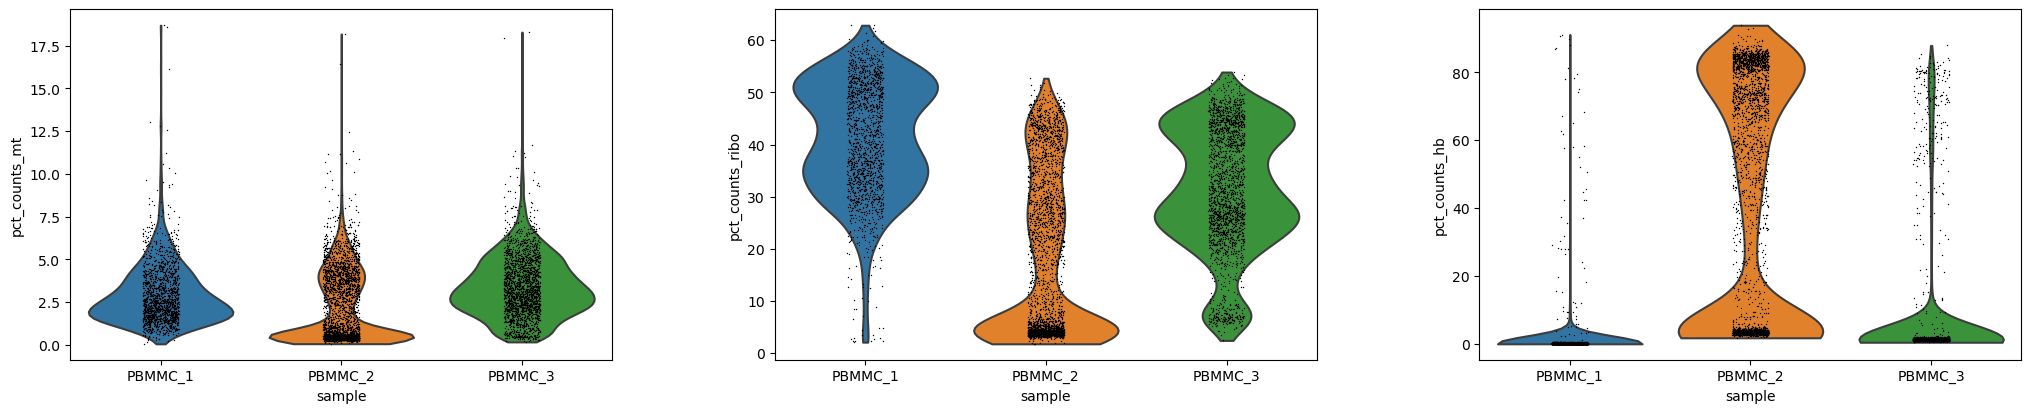

In [19]:
# Violin plots for each sample separately

#Exercise 3 Answer Code

You can see that PBMMC-2 is quite different from the two others, it has a group of cells with very low ribosomal counts and one with very high globin counts. Maybe these two percentages are negatively correlated? Let’s have a look, by plotting the two percentages against each other:

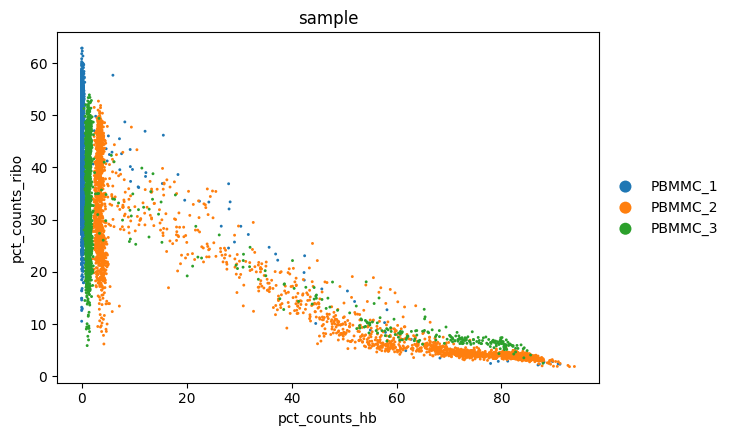

In [15]:
sc.pl.scatter(adata, x="pct_counts_hb", y="pct_counts_ribo", color='sample')

## Plotting genes express as a function of total counts

We can also evaluate the relative expression of other genes in our dataset, for example, the ones that are most highly expressed. Some very highly expressed genes might point to a technical cause, and we might consider to remove them. Below you will find a simple function to generate a boxplot of relative counts per gene per cell:

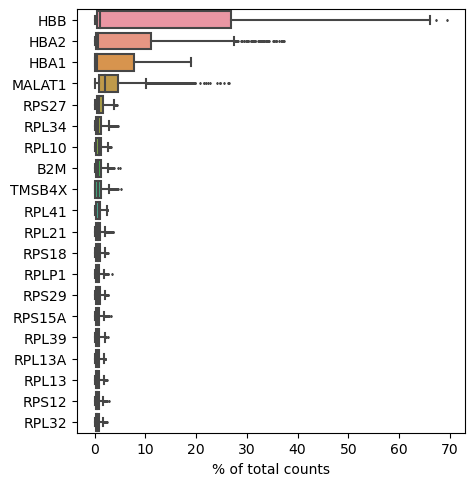

In [20]:
sc.pl.highest_expr_genes(adata, n_top=20)